# Model Training, Testing and Evaluation

In [1]:
#import libraries
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import nltk
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, average_precision_score, auc
from mlxtend.plotting import plot_confusion_matrix
from sklearn.svm import LinearSVC

In [2]:
os.chdir('C:\\Users\\Sean\\Desktop\excel_data')

In [3]:
df = pd.read_csv("clean_df_vader.csv")

In [4]:
rating_score = []

for i in df.rating:
    if i <= 5:
        score = 0
    else:
        score = 1
    rating_score.append(score)

df["rating_score"] = rating_score
df.head()

,Unnamed: 0,date,drug_name,condition,rating,comment,final_clean,sentiment_vader,rating_score
0,0,"March 21, 2019",Abacavir,HIV Infection,1,"""Sorry to say this drug Abacavir definitely ha...",sorry say drug abacavir definitely bad unpleas...,-0.9136,0
1,1,"September 1, 2019",Abacavir and lamivudine,HIV Infection,7,"""taking this combo for 2 months now together w...",take combo month together rezolsta feel nausea...,-0.5106,1
2,2,"August 10, 2019",Abacavir and lamivudine,HIV Infection,10,"""My wife and I have been on Epzicom since 200...",wife epzicom since along viramune work no side...,-0.1027,1
3,3,"August 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""Epzicom Reyataz AND Norvir triple combination...",epzicom reyataz norvir triple combination expe...,0.2732,1
4,4,"March 16, 2013",Abacavir and lamivudine,HIV Infection,10,"""I've used this since first diagnosed and star...",use since first diagnose start haart work extr...,0.4536,1


In [5]:
svm_data = pd.DataFrame({"final_clean" : df["final_clean"], "rating_score" : df["rating_score"]})
train, test = train_test_split(svm_data, test_size=0.3, random_state=101)

In [6]:
rating_train_1 = train[train['rating_score']==0]
rating_train_2 = train[train['rating_score']==1]

print("shape for rating_train_1: " + str(rating_train_1.shape))
print("shape for rating_train_2: " + str(rating_train_2.shape))

shape for rating_train_1: (35744, 2)
shape for rating_train_2: (52302, 2)


In [7]:
rating_train_1 = train[train['rating_score']==0].sample(45000,replace=True, random_state=101)
rating_train_2 = train[train['rating_score']==1].sample(45000,replace=True, random_state=101)

rating_training_bs = pd.concat([rating_train_1, rating_train_2])

print("training dataset shape: " + str(train.shape))
print("testing dataset shape: " + str(test.shape))
print("rating_training_bs shape: " + str(rating_training_bs.shape))

training dataset shape: (88046, 2)
testing dataset shape: (37734, 2)
rating_training_bs shape: (90000, 2)


In [8]:
train['rating_score'].value_counts(normalize=True)
rating_training_bs['rating_score'].value_counts(normalize=True)

1    0.5
0    0.5
Name: rating_score, dtype: float64

In [9]:
Train_X = rating_training_bs["final_clean"]
Train_Y = rating_training_bs["rating_score"]
Test_X = test["final_clean"]
Test_Y = test["rating_score"]

Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [10]:
SVM = LinearSVC(random_state=1)

In [11]:
def tf_vec_ngram(params, X_train, y_train):
    tfvec_p = TfidfVectorizer(ngram_range=(params))
    tfvec_p.fit(X_train.astype(str))
    X_train_tfvec_p = tfvec_p.transform(X_train.astype(str))
    tfvec_score_p = cross_val_score(SVM, X_train_tfvec_p, y_train, cv=10)
    return tfvec_score_p.mean()

params = [(1,1), (1,2), (1,3)] 

ngram_scores = []

for p in params:
    ngram_scores.append(tf_vec_ngram(p, Train_X, Train_Y)*100)
    
ngrams = ['n_gram_(1,1)','n_gram_(1,2)','n_gram_(1,3)']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2])

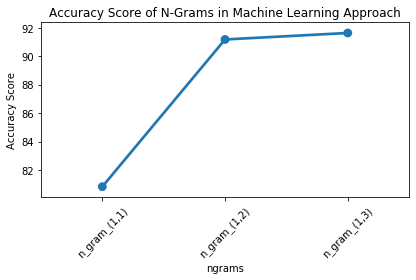

In [12]:
# plot scores on graph
sns.pointplot(x='params', y='scores', data=ngram_df)
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.title('Accuracy Score of N-Grams in Machine Learning Approach')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('SVM ngram accuracy for rating.png')

In [13]:
ngram_df

,params,scores
0,"n_gram_(1,1)",80.835556
1,"n_gram_(1,2)",91.176667
2,"n_gram_(1,3)",91.632222


In [14]:
def tf_vec_max_features(params, Train_X, Train_Y):
    tfvec_p = TfidfVectorizer(max_features=params)
    tfvec_p.fit(Train_X.astype(str))
    Train_X_tfvec_p = tfvec_p.transform(Train_X.values.astype(str))
    tfvec_score_p = cross_val_score(SVM, Train_X_tfvec_p, Train_Y, cv=10)
    return tfvec_score_p.mean()

max_features_params = [None, 1000, 5000, 10000, 20000]

max_features_scores = [tf_vec_max_features(p, Train_X, Train_Y) for p in max_features_params]

max_features = ['max_f_'+str(p) for p in max_features_params]

max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
max_features_df.scores = max_features_df.scores*100

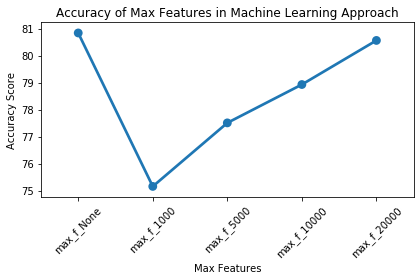

In [15]:
sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('Max Features')
plt.xticks(rotation=45)
plt.title('Accuracy of Max Features in Machine Learning Approach')
#plt.show()
plt.tight_layout()
plt.savefig('SVM Max_features rating.png')

In [16]:
max_features_df

,params,scores
0,max_f_None,80.835556
1,max_f_1000,75.154444
2,max_f_5000,77.506667
3,max_f_10000,78.926667
4,max_f_20000,80.558889


In [17]:
def tf_vec_max_df(params, Train_X, Train_Y):
    tfvec_p = TfidfVectorizer(max_df=params)
    tfvec_p.fit(Train_X.astype(str))
    X_train_tfvec_p = tfvec_p.transform(Train_X.astype(str))
    tfvec_score_p = cross_val_score(SVM, X_train_tfvec_p, Train_Y, cv=10)
    return tfvec_score_p.mean()

max_df_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [tf_vec_max_df(p, Train_X, Train_Y) for p in max_df_params]
max_df = ['max_df_'+str(p) for p in max_df_params]

max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
max_df_df.scores = max_df_df.scores*100

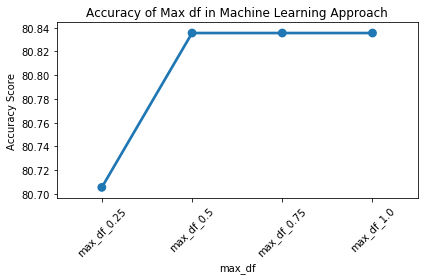

In [18]:
sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.xticks(rotation=45)
plt.title('Accuracy of Max df in Machine Learning Approach')
#plt.show()
plt.tight_layout()
plt.savefig('SVM max_df accuracy rating.png')

In [19]:
max_df_df

,params,scores
0,max_df_0.25,80.705556
1,max_df_0.5,80.835556
2,max_df_0.75,80.835556
3,max_df_1.0,80.835556


In [20]:
def tf_vec_min_df(params, Train_X, Train_Y):
    tfvec_p = TfidfVectorizer(min_df=params)
    tfvec_p.fit(Train_X.astype(str))
    X_train_tfvec_p = tfvec_p.transform(Train_X.astype(str))
    tfvec_score_p = cross_val_score(SVM, X_train_tfvec_p, Train_Y, cv=10)
    return tfvec_score_p.mean()

min_df_params = [1, 100, 1000, 5000, 10000]
min_df_scores = [tf_vec_min_df(p, Train_X, Train_Y) for p in min_df_params]
min_df = ['min_df_'+str(p) for p in min_df_params]

min_df_df = pd.DataFrame({'params':min_df, 'scores':min_df_scores}, index=[0,1,2,3,4])
min_df_df.scores = min_df_df.scores*100

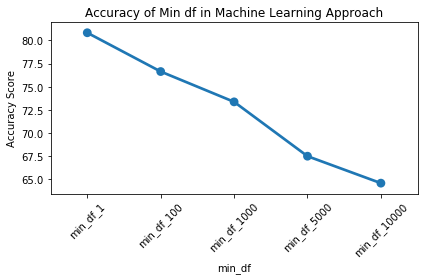

In [21]:
sns.pointplot(x='params', y='scores', data =min_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('min_df')
plt.xticks(rotation=45)
plt.title('Accuracy of Min df in Machine Learning Approach')
plt.tight_layout()
plt.savefig('SVM min_df accuracy rating.png')

In [22]:
min_df_df

,params,scores
0,min_df_1,80.835556
1,min_df_100,76.647778
2,min_df_1000,73.375556
3,min_df_5000,67.511111
4,min_df_10000,64.601111


In [23]:
SVM = LinearSVC(random_state=0, loss="hinge")

ngram_list = [(1,1), (1,2), (1,3)]

score_list = []

for i in ngram_list:
    tfvec_b = TfidfVectorizer(ngram_range=i, max_df=0.5)
    
    # fit the training data
    tfvec_b.fit(Train_X.astype(str))
    
    #transform training data into matrix
    X_train_cvec = tfvec_b.transform(Train_X.astype(str))

    sv_params = {'C':[0.1, 1],
                 'intercept_scaling':[1, 100,500]}

    # gridsearchCV
    svm_grid = GridSearchCV(SVM, param_grid=sv_params, cv=10, n_jobs=-1, verbose=1)

    # fit with the tranformed matrix
    svm_grid.fit(X_train_cvec, Train_Y)

    print('Best Score for: ' + str(i) + " is " + str(svm_grid.best_score_))

    # assign the best estimator
    best_svm = svm_grid.best_estimator_
    print('Best Params for: ' + str(i) + " is " + str(svm_grid.best_params_))
    score_list.append(svm_grid.best_score_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.6min finished


Best Score for: (1, 1) is 0.7952444444444444
Best Params for: (1, 1) is {'C': 1, 'intercept_scaling': 1}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 38.3min finished


Best Score for: (1, 2) is 0.8956888888888889
Best Params for: (1, 2) is {'C': 1, 'intercept_scaling': 1}
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 60.1min finished


Best Score for: (1, 3) is 0.9107
Best Params for: (1, 3) is {'C': 1, 'intercept_scaling': 1}


In [24]:
ngram_df = pd.DataFrame({"n_gram": ngram_list, "score":score_list})
ngram_df.to_csv("ngram_score_rating.csv")

In [28]:
#fit in best parameters
tfvec_b = TfidfVectorizer(ngram_range=(1,3), max_df=0.5)

# fit the training data
tfvec_b.fit(Train_X.astype(str))

#transform training data into matrix
X_train_cvec = tfvec_b.transform(Train_X.astype(str))

sv_params = {'C':[1], 'intercept_scaling':[1]}

# gridsearchCV
svm_grid = GridSearchCV(SVM, param_grid=sv_params, cv=10, n_jobs=-1, verbose=1)

# fit with the tranformed matrix
svm_grid.fit(X_train_cvec, Train_Y)

best_svm = svm_grid.best_estimator_

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.4min finished


In [29]:
SVM = LinearSVC(random_state=0, loss="hinge", C=1, intercept_scaling=1)

test_tfidf = TfidfVectorizer(ngram_range=(1,3), max_df=0.5)
test_tfidf.fit(Test_X)
X_test_cvec = tfvec_b.transform(Test_X)

# Train the model
SVM.fit(X_train_cvec, Train_Y)

# make prediction
y_pred = SVM.predict(X_test_cvec)

# Compare predicted y to actual y 
accuracy = (y_pred == Test_Y).mean()
print(accuracy)

0.7878306036995812


In [30]:
cm_cv = confusion_matrix(Test_Y, y_pred)

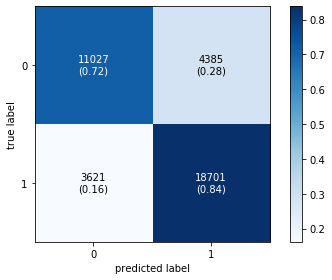

In [34]:
fig,ax = plot_confusion_matrix(cm_cv, show_normed=True, colorbar=True, show_absolute=True)
plt.tight_layout()
plt.savefig('confusion_matrix_rating.png')

In [29]:
print(classification_report(Test_Y, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73     15412
           1       0.81      0.84      0.82     22322

    accuracy                           0.79     37734
   macro avg       0.78      0.78      0.78     37734
weighted avg       0.79      0.79      0.79     37734



In [30]:
report = classification_report(Test_Y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.752799,0.715481,0.733666,15412.000000
1,0.810058,0.837783,0.823687,22322.000000
accuracy,0.787831,0.787831,0.787831,0.787831
macro avg,0.781429,0.776632,0.778677,37734.000000
weighted avg,0.786671,0.787831,0.786919,37734.000000


In [31]:
report_df.to_csv("classication_report_svm_rating.csv")